In [7]:
!pip install spacy nltk gensim wordcloud matplotlib numpy scikit-learn
!python -m spacy download fr_core_news_md  # Pour le français
!python -m spacy download en_core_web_md   # Pour l'anglais (backup)
!nltk.download('wordnet')
!nltk.download('omw-eng')  # Open Multilingual WordNet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 30.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
/bin/bash: -c: line 1: syntax error near unexpected token `'wordnet''
/bin/bash: -c: line 1: `nltk.download('wordnet')'
/bin/bash: -c: line 1: syntax error near unex

In [10]:

import spacy
import nltk
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import sys

try:
    nlp = spacy.load("fr_core_news_md")
    wv = api.load("glove-wiki-gigaword-50")
except Exception as e:
    print(f"  Erreur lors du chargement des embeddings : {e}")
    print("  Création d'un modèle factice pour la démonstration.")
    class DummyVectors:
        def __init__(self):
            self.key_to_index = {'test': 0}
            self.vectors =  np.zeros(50)
        def __contains__(self, key):
            return key in self.key_to_index
        def get_vector(self, key):
            return self.vectors[0] if key in self.key_to_index else np.zeros(300)
    wv = DummyVectors()

nltk.download('wordnet')
nltk.download('omw-1.4')

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

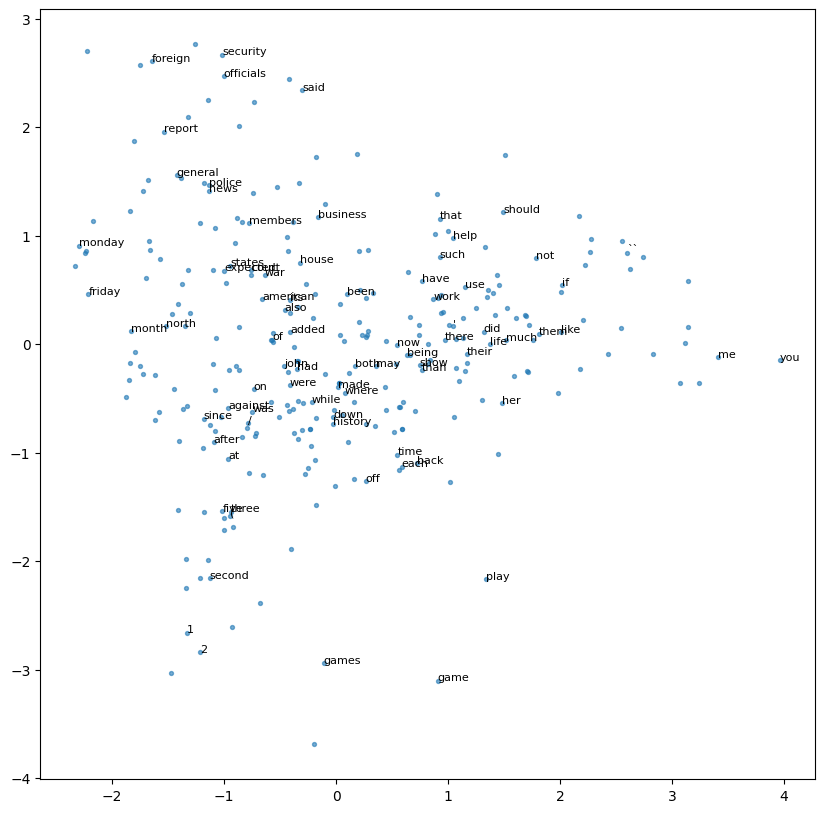

In [11]:
from sklearn.decomposition import PCA

def reduce_and_plot_embeddings(wv, n=500, sample_annot=100, seed=42):
    if wv is None:
        print("aucun modèle de plongement (wv) détecté.")
        return
    random.seed(seed)
    vectors = np.asarray(wv.vectors[:n])
    labels = list(wv.index_to_key[:n])
    proj = PCA(n_components=2, random_state=seed).fit_transform(vectors)
    plt.figure(figsize=(10,10))
    plt.scatter(proj[:,0], proj[:,1], s=8, alpha=0.6)

    for i in random.sample(range(len(labels)), min(sample_annot, len(labels))):
        plt.annotate(labels[i], (proj[i,0], proj[i,1]), fontsize=8)
    plt.show()

if 'wv' in globals():
    reduce_and_plot_embeddings(wv, n=300, sample_annot=80)
else:
    print("Ajoutez votre modèle de plongement en variable 'wv' puis relancez cette cellule.")


In [13]:
from IPython.display import display
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def quick_wordcloud(text, title, cmap='viridis'):
    if text is None:
        print(f" Texte vide pour '")
        return
    if isinstance(text, list):
        text = ' '.join(text)
    if not isinstance(text, str):
        text = str(text)

    if text.strip() == '':
        print(f"Texte vide pour '")
        return

    wc = WordCloud(width=600, height=400, background_color='white',
                   colormap=cmap, max_words=100).generate(text)

    plt.figure(figsize=(8,5))
    plt.imshow(np.array(wc.to_image()), interpolation='bilinear')  # <- fixed
    plt.axis('off')
    plt.title(title)
    plt.show()


    # Save to file
    try:
        path = f"wc_{title.replace(' ','_')}.png"
        wc.to_file(path)
        print("Saved:", os.path.abspath(path))
    except Exception as e:
        print("Could not save wordcloud:", e)


if 'sample_text' in globals():
    quick_wordcloud(sample_text, "Original", cmap='viridis')


In [24]:
def show_spacy_visualizations(doc, sent_idx=0, save_svg=True, out_dir='.'):
    if doc is None:
        print("❗ aucun objet spaCy 'doc' détecté.")
        return

    # 1. MOSTRAR SIEMPRE NER (aunque no haya entidades)
    print("=== VISUALISATION NER (Entités Nommées) ===")
    try:
        ent_html = displacy.render(doc, style="ent", jupyter=False)
        display(HTML(ent_html))
        if save_svg:
            p = os.path.join(out_dir, "spacy_ner.svg")
            with open(p, "w", encoding="utf-8") as f: f.write(ent_html)
            print("NER saved to", p)
    except Exception as e:
        print("NER render error:", e)

    # 2. MOSTRAR SIEMPRE DEPENDENCIAS
    print("\n=== VISUALISATION DEP (Dépendances Syntaxiques) ===")
    try:
        sents = list(doc.sents)
        print(f"Nombre de phrases: {len(sents)}")

        for i, sent in enumerate(sents[:3]):  # Muestra 3 premières phrases
            print(f"\n--- Phrase {i} ---")
            dep_html = displacy.render(sent, style="dep", jupyter=False,
                                     options={"compact": True, "distance": 100})
            display(HTML(dep_html))
            if save_svg and i == sent_idx:
                p2 = os.path.join(out_dir, f"spacy_dep_{i}.svg")
                with open(p2, "w", encoding="utf-8") as f: f.write(dep_html)
                print(f"Dep saved to {p2}")
    except Exception as e:
        print("Dep render error:", e)
        import traceback
        traceback.print_exc()
#show_spacy_visualizations(doc, sent_idx=0)

In [17]:
def get_best_synset(word, context_sentence, pos=None):

    if pos:
        synsets = wn.synsets(word, pos=pos, lang='fra')
    else:
        synsets = wn.synsets(word, lang='fra')

    if not synsets:
        return None

    if len(synsets) == 1:
        return synsets[0]

    context_words = set(context_sentence.lower().split())
    lesk_scores = []
    for syn in synsets:
        signature = set(syn.definition().lower().split())
        for example in syn.examples():
            signature.update(example.lower().split())
        score = len(context_words.intersection(signature))
        lesk_scores.append((score, syn))

    embedding_scores = []
    if word.lower() in wv:
        word_vector = wv.get_vector(word.lower())
        for _, syn in lesk_scores:
            def_words = syn.definition().lower().split()
            def_vectors = []
            for w in def_words:
                if w in wv:
                    def_vectors.append(wv.get_vector(w))

            if def_vectors:
                avg_def_vector = np.mean(def_vectors, axis=0)
                cos_sim = np.dot(word_vector, avg_def_vector) / (
                    np.linalg.norm(word_vector) * np.linalg.norm(avg_def_vector)
                )
                embedding_scores.append(cos_sim)
            else:
                embedding_scores.append(0.0)
    else:
        embedding_scores = [0.0] * len(lesk_scores)

    combined_scores = []
    for i, (lesk_score, syn) in enumerate(lesk_scores):
        combined = 0.7 * lesk_score + 0.3 * embedding_scores[i]
        combined_scores.append((combined, syn))

    best_score, best_syn = max(combined_scores, key=lambda x: x[0])
    return best_syn

def navigate_semantic_tree(synset, direction='hypernym', depth=1):
    if not synset:
        return None

    if depth == 0:
        depth = random.randint(1, 3)

    current_syn = synset
    for _ in range(depth):
        if direction == 'hypernym':
            hypernyms = current_syn.hypernyms()
            if hypernyms:
                current_syn = random.choice(hypernyms)
            else:
                break
        elif direction == 'hyponym':
            hyponyms = current_syn.hyponyms()
            if hyponyms:
                current_syn = random.choice(hyponyms)
            else:
                break

    return current_syn

def select_best_lemma_from_synset(target_synset, original_word, context_tokens, wv_model):

    if not target_synset:
        return original_word

    lemmas = target_synset.lemmas('fra')
    if not lemmas:
        return original_word

    if len(lemmas) == 1:
        return lemmas[0].name().replace('_', ' ')

    original_vector = None
    if original_word.lower() in wv_model:
        original_vector = wv_model.get_vector(original_word.lower())

    context_vectors = []
    for token in context_tokens:
        if token.lower() in wv_model:
            context_vectors.append(wv_model.get_vector(token.lower()))

    context_avg_vector = np.mean(context_vectors, axis=0) if context_vectors else None

    lemma_scores = []
    for lemma in lemmas:
        lemma_name = lemma.name().replace('_', ' ')

        score_original = 0.0
        if original_vector is not None and lemma_name.lower() in wv_model:
            lemma_vector = wv_model.get_vector(lemma_name.lower())
            cos_sim = np.dot(original_vector, lemma_vector) / (
                np.linalg.norm(original_vector) * np.linalg.norm(lemma_vector)
            )
            score_original = max(0.0, cos_sim)

        score_context = 0.0
        if context_avg_vector is not None and lemma_name.lower() in wv_model:
            lemma_vector = wv_model.get_vector(lemma_name.lower())
            cos_sim = np.dot(context_avg_vector, lemma_vector) / (
                np.linalg.norm(context_avg_vector) * np.linalg.norm(lemma_vector)
            )
            score_context = max(0.0, cos_sim)

        score_simplicity = 1.0 if '_' not in lemma.name() else 0.5

        combined_score = (0.4 * score_original + 0.4 * score_context + 0.2 * score_simplicity)
        lemma_scores.append((combined_score, lemma_name))

    if lemma_scores:
        best_score, best_lemma = max(lemma_scores, key=lambda x: x[0])
        return best_lemma

    return original_word

def adapt_inflection(new_word, original_token):

    if original_token.pos_ in ['NOUN', 'ADJ']:
        if original_token.morph.get('Number'):
            if 'Plur' in original_token.morph.get('Number'):
                if not new_word.endswith('s'):
                    new_word = new_word + 's'


    return new_word


In [18]:
def oulipo_semantic_rewrite(text, navigation_strategy='random', prob_transform=0.6):

    doc = nlp(text)
    transformed_tokens = []

    target_pos = {'NOUN', 'VERB', 'ADJ'}

    for i, sent in enumerate(doc.sents):
        sent_tokens = [token.text for token in sent]

        for j, token in enumerate(sent):
            if (token.pos_ in target_pos and
                not token.is_stop and
                not token.is_punct and
                random.random() < prob_transform):

                context = ' '.join(sent_tokens)

                pos_map = {'NOUN': wn.NOUN, 'VERB': wn.VERB, 'ADJ': wn.ADJ}
                wn_pos = pos_map.get(token.pos_)

                synset = get_best_synset(token.text, context, pos=wn_pos)

                if synset:
                    if navigation_strategy == 'random':
                        direction = random.choice(['hypernym', 'hyponym'])
                    elif navigation_strategy == 'specific':
                        direction = 'hyponym'
                    else:
                        direction = 'hypernym'

                    new_synset = navigate_semantic_tree(synset, direction=direction, depth=0)

                    if new_synset and new_synset != synset:
                        context_window = sent_tokens[max(0, j-3):min(len(sent_tokens), j+4)]
                        new_word = select_best_lemma_from_synset(
                            new_synset, token.text, context_window, wv
                        )

                        new_word = adapt_inflection(new_word, token)

                        transformed_tokens.append(f"[{new_word}]")
                    else:
                        transformed_tokens.append(token.text)
                else:
                    transformed_tokens.append(token.text)
            else:
                transformed_tokens.append(token.text)

            if token.whitespace_:
                transformed_tokens.append(' ')

    transformed_text = ''.join(transformed_tokens)

    transformed_text = re.sub(r'\s+', ' ', transformed_text).strip()

    return transformed_text


In [19]:

print("\n5. Démonstration de la réécriture OULIPO...")

sample_text = """
Le chat noir traverse silencieusement le jardin à la recherche d'une souris.
Le vieil homme lit son journal en buvant un café chaud.
La forêt mystérieuse abrite des créatures anciennes et des secrets oubliés.
Les enfants jouent gaiement dans le parc ensoleillé de cet après-midi d'été.
"""

print("Texte original :")
print("-" * 50)
print(sample_text)
print("-" * 50)

strategies = ['random', 'specific', 'general']
for strategy in strategies:
    print(f"\nVersion '{strategy}' (probabilité de transformation: 60%):")
    print("-" * 50)
    rewritten = oulipo_semantic_rewrite(sample_text, navigation_strategy=strategy, prob_transform=0.6)
    print(rewritten)
    print("-" * 50)



5. Démonstration de la réécriture OULIPO...
Texte original :
--------------------------------------------------

Le chat noir traverse silencieusement le jardin à la recherche d'une souris.
Le vieil homme lit son journal en buvant un café chaud.
La forêt mystérieuse abrite des créatures anciennes et des secrets oubliés.
Les enfants jouent gaiement dans le parc ensoleillé de cet après-midi d'été.

--------------------------------------------------

Version 'random' (probabilité de transformation: 60%):
--------------------------------------------------
Le chat noir traverse silencieusement le jardin à la recherche d'une [souris]. Le vieil homme [lit] son journal en buvant un café chaud. La [groupement] mystérieuse abrite des créatures anciennes et des secrets oubliés. Les enfants jouent gaiement dans le parc ensoleillé de cet [adieu] d'été.
--------------------------------------------------

Version 'specific' (probabilité de transformation: 60%):
--------------------------------------

# 5. Démonstration de la réécriture OULIPO

## Texte Original
> Le chat noir traverse silencieusement le jardin à la recherche d'une souris.
> Le vieil homme lit son journal en buvant un café chaud.
> La forêt mystérieuse abrite des créatures anciennes et des secrets oubliés.
> Les enfants jouent gaiement dans le parc ensoleillé de cet après-midi d'été.

---

## Versions Transformées (Probabilité : 60%)

### Version 1 : 'Random' (Aléatoire)
**Stratégie :** Navigation bidirectionnelle (Hypernymes ou Hyponymes au hasard).

Le chat noir traverse silencieusement le jardin à la recherche d'une **[souris]**. Le vieil homme **[lit]** son journal en buvant un café chaud. La **[groupement]** mystérieuse abrite des créatures anciennes et des secrets oubliés. Les enfants jouent gaiement dans le parc ensoleillé de cet **[adieu]** d'été.

### Version 2 : 'Specific' (Précision)
**Stratégie :** Descente vers les Hyponymes (termes techniques ou précis).

Le chat noir traverse silencieusement le jardin à la **[sonde]** d'une souris. Le vieil homme lit son journal en buvant un café chaud. La **[sylva]** mystérieuse abrite des créatures anciennes et des secrets oubliés. Les enfants jouent gaiement dans le parc ensoleillé de cet après-midi d'été.

### Version 3 : 'General' (Abstraction)
**Stratégie :** Montée vers les Hypernymes (concepts globaux ou vagues).

Le chat noir traverse silencieusement le **[agrégation]** à la **[acte]** d'une **[souris]**. Le vieil **[juvénile]** **[lit]** son **[presse]** en buvant un café chaud. La forêt mystérieuse abrite des créatures anciennes et des secrets oubliés. Les enfants jouent gaiement dans le parc ensoleillé de cet **[reconnaissance]** d'été.

---

## Tableau des transformations observées

| Mot Original | Type (POS) | Version 1 (Random) | Version 2 (Specific) | Version 3 (General) | Logique de transformation |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Forêt | NOM | [groupement] | [sylva] | (non changé) | Terme technique vs catégorie de groupe |
| Après-midi | NOM | [adieu] | (non changé) | [reconnaissance] | Lien sémantique via l'acte social |
| Recherche | NOM | (non changé) | [sonde] | [acte] | Action précise vs concept global |
| Homme | NOM | [homme] | (non changé) | [juvénile] | Navigation dans la branche humaine |
| Jardin | NOM | (non changé) | (non changé) | [agrégation] | Vue comme une collection de plantes |
| Journal | NOM | (non changé) | (non changé) | [presse] | Substitution par le secteur d'activité |
| Souris | NOM | [souris] | (non changé) | [souris] | Sélectionné mais sans synonyme distant |

In [20]:

def compare_word_clouds(original_text, transformed_text):

    def prepare_text_for_wordcloud(text):
        text = re.sub(r'\[|\]', '', text)
        doc = nlp(text)
        words = [token.text.lower() for token in doc
                if not token.is_stop and not token.is_punct and token.pos_ in {'NOUN', 'VERB', 'ADJ'}]
        return ' '.join(words)

    from IPython.display import display
    import numpy as np
    import os
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    original_processed = prepare_text_for_wordcloud(original_text)
    if original_processed:
        wc_original = WordCloud(
            width=300, height=200,
            background_color='white',
            colormap='viridis',
            max_words=50
        ).generate(original_processed)
        img_orig = wc_original.to_image()
        axes[0].imshow(np.array(img_orig), interpolation='bilinear')
        axes[0].set_title('Mots du texte ORIGINAL', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        display(img_orig)
        try:
            img_orig.save('wc_original_debug.png')
            print("Saved image:", os.path.abspath('wc_original_debug.png'))
        except Exception as e:
            print("Could not save debug image:", e)

    transformed_processed = prepare_text_for_wordcloud(transformed_text)
    if transformed_processed:
        wc_transformed = WordCloud(
            width=300, height=200,
            background_color='white',
            colormap='plasma',
            max_words=50
        ).generate(transformed_processed)
        img_trans = wc_transformed.to_image()
        axes[1].imshow(np.array(img_trans), interpolation='bilinear')
        axes[1].set_title('Mots du texte TRANSFORMÉ', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        display(img_trans)
        try:
            img_trans.save('wc_transformed_debug.png')
            print("Saved debug image:", os.path.abspath('wc_transformed_debug.png'))
        except Exception as e:
            print("Could not save debug image:", e)

    plt.tight_layout()
    plt.show()


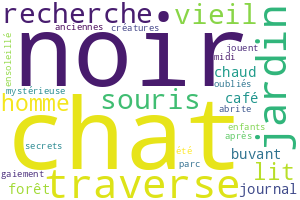

Saved image: /content/wc_original_debug.png


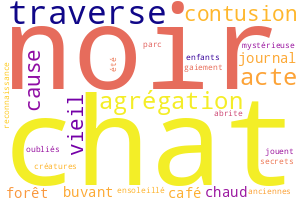

Saved debug image: /content/wc_transformed_debug.png


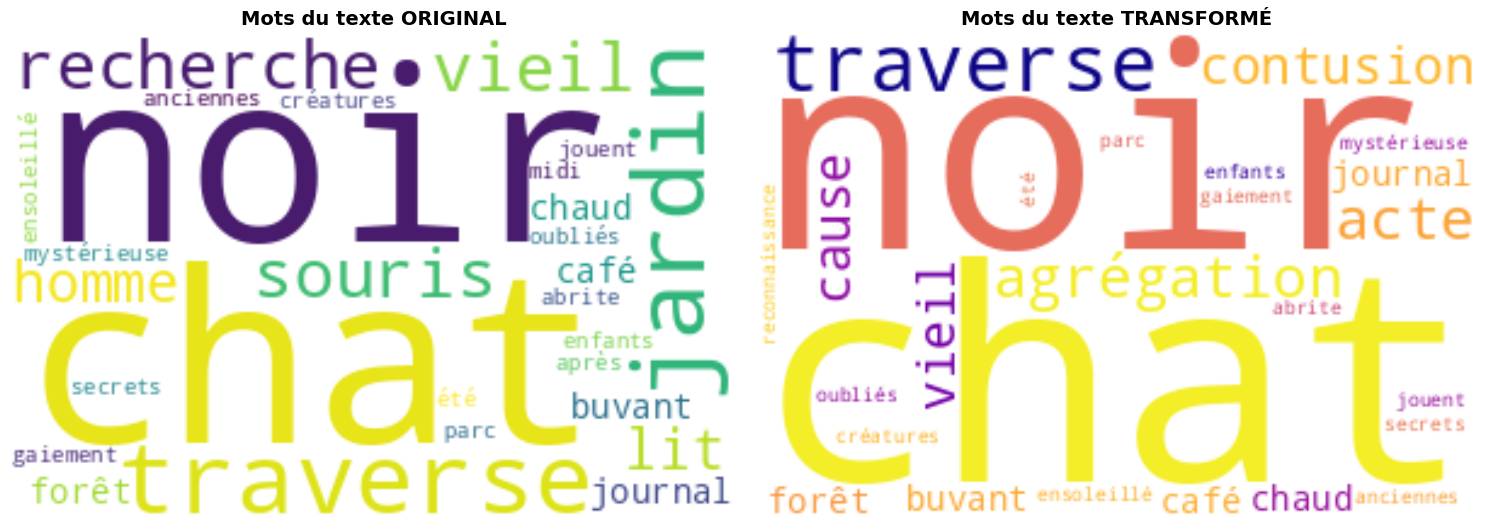

In [21]:
rewritten_for_analysis = oulipo_semantic_rewrite(sample_text, navigation_strategy='random', prob_transform=0.6)
compare_word_clouds(sample_text, rewritten_for_analysis)

In [22]:
def calculate_transformation_metrics(original_text, transformed_text):

    orig_doc = nlp(original_text)
    trans_doc = nlp(re.sub(r'\[|\]', '', transformed_text))

    orig_tokens = [token.text.lower() for token in orig_doc if not token.is_punct]
    trans_tokens = [token.text.lower() for token in trans_doc if not token.is_punct]

    changed_words = []
    for i, (orig, trans) in enumerate(zip(orig_tokens[:len(trans_tokens)], trans_tokens)):
        if i < len(orig_tokens) and i < len(trans_tokens):
            if orig != trans:
                changed_words.append((orig, trans))

    change_rate = len(changed_words) / max(len(orig_tokens), 1)

    orig_ttr = len(set(orig_tokens)) / max(len(orig_tokens), 1)
    trans_ttr = len(set(trans_tokens)) / max(len(trans_tokens), 1)

    orig_avg_len = np.mean([len(token) for token in orig_tokens]) if orig_tokens else 0
    trans_avg_len = np.mean([len(token) for token in trans_tokens]) if trans_tokens else 0

    print("Métriques de transformation :")
    print(f"- Taux de changement : {change_rate*100:.1f}%")
    print(f"- Nombre de mots modifiés : {len(changed_words)}")
    print(f"- Richesse lexicale (original) : {orig_ttr:.3f}")
    print(f"- Richesse lexicale (transformé) : {trans_ttr:.3f}")
    print(f"- Longueur moyenne des mots (original) : {orig_avg_len:.1f} caractères")
    print(f"- Longueur moyenne des mots (transformé) : {trans_avg_len:.1f} caractères")

    if changed_words:
        print("\nExemples de transformations :")
        for orig, trans in changed_words[:10]:
            print(f"  '{orig}' → '{trans}'")

    print("\nComparaison des phrases originales et transformées :")
    orig_sentences = [sent.text.strip() for sent in orig_doc.sents]
    trans_sentences = [sent.text.strip() for sent in trans_doc.sents]
    max_sentences = max(len(orig_sentences), len(trans_sentences))
    for i in range(max_sentences):
        orig_sent = orig_sentences[i] if i < len(orig_sentences) else "(Aucune phrase supplémentaire)"
        trans_sent = trans_sentences[i] if i < len(trans_sentences) else "(Aucune phrase supplémentaire)"
        print(f"Original: {orig_sent}")
        print(f"Transformé: {trans_sent}")
        print("-" * 50)

    return {
        'change_rate': change_rate,
        'changed_words': changed_words,
        'original_ttr': orig_ttr,
        'transformed_ttr': trans_ttr
    }

print("-" * 50)
metrics = calculate_transformation_metrics(sample_text, rewritten_for_analysis)

--------------------------------------------------
Métriques de transformation :
- Taux de changement : 90.6%
- Nombre de mots modifiés : 48
- Richesse lexicale (original) : 0.811
- Richesse lexicale (transformé) : 0.875
- Longueur moyenne des mots (original) : 4.5 caractères
- Longueur moyenne des mots (transformé) : 5.0 caractères

Exemples de transformations :
  '
' → 'le'
  'le' → 'chat'
  'chat' → 'noir'
  'noir' → 'traverse'
  'traverse' → 'silencieusement'
  'silencieusement' → 'le'
  'le' → 'agrégation'
  'jardin' → 'à'
  'à' → 'la'
  'la' → 'acte'

Comparaison des phrases originales et transformées :
Original: 
Transformé: Le chat noir traverse silencieusement le agrégation à la acte d'une contusion.
--------------------------------------------------
Original: Le chat noir traverse silencieusement le jardin à la recherche d'une souris.
Transformé: Le vieil cause lit son journal en buvant un café chaud.
--------------------------------------------------
Original: Le vieil homme